In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

In [54]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [56]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

# dataset

In [57]:
wells = os.listdir(target_folder)
len(wells)

23

In [58]:
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

In [59]:
logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [60]:
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [61]:
X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

In [62]:
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

In [63]:
X = []
for i in X_list_minus:
    X.append(i.values)

In [64]:
X = np.dstack(X)
X = np.rollaxis(X, -1)
X.shape

(5901, 256, 5)

In [65]:
map_well_to_label = {w:i for i, w in enumerate(wells)}

In [66]:
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])
y.shape

(5901,)

In [67]:
class DataSet():
    def __init__(self, data, labels, feature_scales={}, N=25000, length_lim=90, sparse_rate=1):

#         if len(data) > N:
#             sub_inds = np.random.choice(len(data), N, replace=False)
#         else:
#             sub_inds = np.arange(len(data))
        
        self.data = data
        self.data = torch.tensor(self.data).to(torch.float32)
        self.labels = torch.tensor(labels)
        self.sparse_rate = sparse_rate
        self.feature_scales = feature_scales
        
        for f in range(data.shape[2]):
            self.data[:, :, f] = (self.data[:, :, f].T - self.data[:, :, f].mean(axis=1)).T 
            
        for f in range(data.shape[2]):
            if f not in feature_scales:
                std = self.data[:, :, f].ravel().std()
                feature_scales[f] = std
            self.data[:, :, f] = self.data[:, :, f]/feature_scales[f]
            
        self.data = self.data.transpose(1, 2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

In [68]:
torch_dataset = DataSet(X, y, sparse_rate=1)


In [69]:
train_n = 4000
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [70]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [71]:
for x_t, y_t in train_loader:
    print(x_t.shape)
    print(y_t.shape)
    break

torch.Size([64, 5, 256])
torch.Size([64])


---

# Model

In [72]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 2, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose1d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=32):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv1d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv1d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 , features, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose1d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh(),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        return d6
    
        

    def forward(self, x):
#         print('x', x.shape)
        d1 = self.initial_down(x)
#         print('d1', d1.shape)
        d2 = self.down1(d1)
#         print('d2', d2.shape)
        d3 = self.down2(d2)
#         print('d3', d3.shape)
        d4 = self.down3(d3)
#         print('d4', d4.shape)
        d5 = self.down4(d4)
#         print('d5', d5.shape)
        d6 = self.down5(d5)
#         print('d6', d6.shape)
        bottleneck = self.bottleneck(d6)
#         print('bottleneck', bottleneck.shape)
        up1 = self.up1(bottleneck)
#         print('up1', up1.shape)
        if up1.shape != d6.shape:
            up1 = TF.resize(up1, size=d6.shape[1:]) 
        up2 = self.up2(torch.cat([up1, d6], 1))
#         print('up2', up2.shape)
        if up2.shape != d5.shape:
            up2 = TF.resize(up2, size=d5.shape[1:])
        up3 = self.up3(torch.cat([up2, d5], 1))
#         print('up3', up3.shape)
        if up3.shape != d4.shape:
            up3 = TF.resize(up3, size=d4.shape[1:])
        up4 = self.up4(torch.cat([up3, d4], 1))
#         print('up4', up4.shape)
        if up4.shape != d3.shape:
            up4 = TF.resize(up4, size=d3.shape[1:])
        up5 = self.up5(torch.cat([up4, d3], 1))
#         print('up5', up5.shape)
        if up5.shape != d2.shape:
            up5 = TF.resize(up5, size=d2.shape[1:])
        up6 = self.up6(torch.cat([up5, d2], 1))
#         print('up6', up6.shape)
        if up6.shape != d1.shape:
            up6 = TF.resize(up6, size=d1.shape[1:])
        return self.final_up(torch.cat([up6, d1], 1))
        

In [73]:
# check
model_gen = Generator()
for i, data in enumerate(train_loader):
    x, y = data
    print(x.shape)
    print(y.shape)
    out = model_gen(x)
    break

out.shape

torch.Size([64, 5, 256])
torch.Size([64])


torch.Size([64, 5, 256])

In [74]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv1d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x


In [75]:
# check
model_disk = Discriminator()
for i, data in enumerate(train_loader):
    x, y = data
    out = model_disk(x)
    break

out.shape

torch.Size([64, 1, 30])

## inception time

In [76]:
from inceptiontime.src.models.inception import InceptionModel

In [77]:
model_inception = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).cuda()

In [78]:
optimizer = torch.optim.Adam(model_inception.parameters(), lr=1e-3)
best_val_loss = np.inf
patience_counter = 0
best_state_dict = None
criterion = nn.CrossEntropyLoss()

In [79]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100

In [80]:
for epoch in range(num_epochs):
    model_inception.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for x_t, y_t in train_loader:
        x_t = x_t.cuda()
        y_t = y_t.cuda()
        optimizer.zero_grad()
        output = model_inception(x_t)
        loss = criterion(output, y_t)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output, 1)
        all_preds.append(preds)
        all_y.append(y_t)
    train_loss.append(np.mean(epoch_train_loss))
    train_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    epoch_val_loss = []
    model_inception.eval()
    all_preds = []
    all_y = []
    for x_v, y_v in val_loader:
        x_v = x_v.cuda()
        y_v = y_v.cuda()
        with torch.no_grad():
            output = model_inception(x_v)
            loss = criterion(output, y_v)
            epoch_val_loss.append(loss.item())
            _, preds = torch.max(output, 1)
            all_preds.append(preds)
            all_y.append(y_v)
    val_loss.append(np.mean(epoch_val_loss))
    val_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))

    print(f'Epoch: {epoch + 1}, '
          f'Train loss: {round(train_loss[-1], 3)}, '
          f'Val loss: {round(val_loss[-1], 3)}, '
          f'Train acc: {round(train_acc[-1], 3)}, '
          f'Val acc: {round(val_acc[-1], 3)}, ')

Epoch: 1, Train loss: 3.014, Val loss: 2.872, Train acc: 0.082, Val acc: 0.116, 
Epoch: 2, Train loss: 2.802, Val loss: 2.722, Train acc: 0.132, Val acc: 0.15, 
Epoch: 3, Train loss: 2.695, Val loss: 2.616, Train acc: 0.171, Val acc: 0.181, 
Epoch: 4, Train loss: 2.601, Val loss: 2.572, Train acc: 0.193, Val acc: 0.216, 
Epoch: 5, Train loss: 2.546, Val loss: 2.511, Train acc: 0.224, Val acc: 0.209, 
Epoch: 6, Train loss: 2.52, Val loss: 2.487, Train acc: 0.215, Val acc: 0.237, 
Epoch: 7, Train loss: 2.475, Val loss: 2.482, Train acc: 0.23, Val acc: 0.221, 
Epoch: 8, Train loss: 2.485, Val loss: 2.474, Train acc: 0.227, Val acc: 0.207, 
Epoch: 9, Train loss: 2.435, Val loss: 2.415, Train acc: 0.244, Val acc: 0.231, 
Epoch: 10, Train loss: 2.442, Val loss: 2.436, Train acc: 0.227, Val acc: 0.23, 
Epoch: 11, Train loss: 2.406, Val loss: 2.391, Train acc: 0.247, Val acc: 0.234, 
Epoch: 12, Train loss: 2.4, Val loss: 2.42, Train acc: 0.254, Val acc: 0.233, 
Epoch: 13, Train loss: 2.338, Va

## training model

In [81]:
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1

In [82]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion_gan = nn.BCELoss()
criterion_soft_dtw = SoftDTW(use_cuda=True, gamma=0.1)
D_opt = torch.optim.Adam(discriminator.parameters(), lr = lr)
G_opt = torch.optim.Adam(generator.parameters(), lr = lr)
# Soft_dtw_opt = torch.optim.Adam(generator.parameters(), lr = lr)
fixed_noise = torch.randn((batch_size, len(required_params), 64)).to(device)

In [83]:
print('Discriminator paramteres:', sum(p.numel() for p in discriminator.parameters() if p.requires_grad))
print('Generator paramteres:', sum(p.numel() for p in generator.parameters() if p.requires_grad))

Discriminator paramteres: 174625
Generator paramteres: 2419237


In [84]:
writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

In [85]:
G_losses = []
D_losses = []
img_list = []

In [86]:
generator.train()
discriminator.train()

G_loss_list = []
D_loss_list = []

for epoch in range(num_epochs):
    for idx, data_all in enumerate(train_loader):
    
        step = 0
        data, y = data_all
        data = data.to(device)
        y = y.to(device)
        real_data = data.to(device)
        batch_size = real_data.size(0)
        noise = torch.randn(real_data.size(0), len(required_params), 64, device=device)

        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = generator(noise)
#         Ssim_loss = criterion_ssim(real_data, noise)
        # classificator
        output_class = model_inception(data)
        loss_class = criterion(output_class, y)

        disc_real = discriminator(real_data)        
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))        
        disc_fake = discriminator(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2 + loss_class * 0.001
#         + abs(Ssim_loss)
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()

        output = discriminator(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_loss_list.append(G_loss.item())
        D_loss_list.append(D_loss.item())

        if idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(train_loader)} \
            Loss D: {D_loss:.4f}, loss G: {G_loss:.4f}")

            step += 1
            


Epoch [0/100] Batch 0/63             Loss D: 0.7161, loss G: 0.7574
Epoch [0/100] Batch 10/63             Loss D: 0.6652, loss G: 1.1431
Epoch [0/100] Batch 20/63             Loss D: 0.6045, loss G: 1.1677
Epoch [0/100] Batch 30/63             Loss D: 0.4898, loss G: 1.5940
Epoch [0/100] Batch 40/63             Loss D: 0.3864, loss G: 2.0083
Epoch [0/100] Batch 50/63             Loss D: 0.3809, loss G: 1.7813
Epoch [0/100] Batch 60/63             Loss D: 0.5278, loss G: 1.3907
Epoch [1/100] Batch 0/63             Loss D: 0.5190, loss G: 1.4181
Epoch [1/100] Batch 10/63             Loss D: 0.4268, loss G: 2.2039
Epoch [1/100] Batch 20/63             Loss D: 0.3176, loss G: 2.2732
Epoch [1/100] Batch 30/63             Loss D: 0.3069, loss G: 1.9440
Epoch [1/100] Batch 40/63             Loss D: 0.2395, loss G: 2.0777
Epoch [1/100] Batch 50/63             Loss D: 0.2665, loss G: 2.1261
Epoch [1/100] Batch 60/63             Loss D: 0.2839, loss G: 2.2290
Epoch [2/100] Batch 0/63            

Epoch [17/100] Batch 10/63             Loss D: 0.0184, loss G: 4.0496
Epoch [17/100] Batch 20/63             Loss D: 0.0205, loss G: 4.1526
Epoch [17/100] Batch 30/63             Loss D: 0.0190, loss G: 3.7702
Epoch [17/100] Batch 40/63             Loss D: 0.0241, loss G: 4.9939
Epoch [17/100] Batch 50/63             Loss D: 0.0096, loss G: 5.3119
Epoch [17/100] Batch 60/63             Loss D: 0.0275, loss G: 4.1441
Epoch [18/100] Batch 0/63             Loss D: 0.0319, loss G: 3.5360
Epoch [18/100] Batch 10/63             Loss D: 0.0442, loss G: 3.5686
Epoch [18/100] Batch 20/63             Loss D: 0.0162, loss G: 4.2215
Epoch [18/100] Batch 30/63             Loss D: 0.0286, loss G: 4.1081
Epoch [18/100] Batch 40/63             Loss D: 0.0190, loss G: 4.2211
Epoch [18/100] Batch 50/63             Loss D: 0.0146, loss G: 4.5587
Epoch [18/100] Batch 60/63             Loss D: 0.0201, loss G: 4.0667
Epoch [19/100] Batch 0/63             Loss D: 0.0148, loss G: 4.1076
Epoch [19/100] Batch 1

Epoch [34/100] Batch 10/63             Loss D: 0.0055, loss G: 5.3012
Epoch [34/100] Batch 20/63             Loss D: 0.0047, loss G: 6.2505
Epoch [34/100] Batch 30/63             Loss D: 0.0039, loss G: 5.9023
Epoch [34/100] Batch 40/63             Loss D: 0.0049, loss G: 5.5810
Epoch [34/100] Batch 50/63             Loss D: 0.0057, loss G: 5.5355
Epoch [34/100] Batch 60/63             Loss D: 0.0057, loss G: 5.4745
Epoch [35/100] Batch 0/63             Loss D: 0.0075, loss G: 5.8303
Epoch [35/100] Batch 10/63             Loss D: 0.0052, loss G: 6.3244
Epoch [35/100] Batch 20/63             Loss D: 0.1852, loss G: 6.2260
Epoch [35/100] Batch 30/63             Loss D: 0.0047, loss G: 6.0027
Epoch [35/100] Batch 40/63             Loss D: 0.0078, loss G: 6.1061
Epoch [35/100] Batch 50/63             Loss D: 0.0093, loss G: 6.8506
Epoch [35/100] Batch 60/63             Loss D: 0.0059, loss G: 5.9742
Epoch [36/100] Batch 0/63             Loss D: 0.0057, loss G: 8.1029
Epoch [36/100] Batch 1

Epoch [51/100] Batch 10/63             Loss D: 0.0027, loss G: 9.1520
Epoch [51/100] Batch 20/63             Loss D: 0.0024, loss G: 7.4720
Epoch [51/100] Batch 30/63             Loss D: 0.0031, loss G: 6.8990
Epoch [51/100] Batch 40/63             Loss D: 0.0025, loss G: 7.0921
Epoch [51/100] Batch 50/63             Loss D: 0.0024, loss G: 7.1992
Epoch [51/100] Batch 60/63             Loss D: 0.0026, loss G: 6.5461
Epoch [52/100] Batch 0/63             Loss D: 0.0021, loss G: 7.2300
Epoch [52/100] Batch 10/63             Loss D: 0.0026, loss G: 6.4950
Epoch [52/100] Batch 20/63             Loss D: 0.0025, loss G: 6.6707
Epoch [52/100] Batch 30/63             Loss D: 0.0033, loss G: 6.7196
Epoch [52/100] Batch 40/63             Loss D: 0.0030, loss G: 6.9223
Epoch [52/100] Batch 50/63             Loss D: 0.0023, loss G: 6.7734
Epoch [52/100] Batch 60/63             Loss D: 0.0029, loss G: 7.1455
Epoch [53/100] Batch 0/63             Loss D: 0.0036, loss G: 6.7782
Epoch [53/100] Batch 1

Epoch [68/100] Batch 10/63             Loss D: 0.0022, loss G: 7.3530
Epoch [68/100] Batch 20/63             Loss D: 0.0023, loss G: 7.3399
Epoch [68/100] Batch 30/63             Loss D: 0.0023, loss G: 7.5400
Epoch [68/100] Batch 40/63             Loss D: 0.0025, loss G: 7.4716
Epoch [68/100] Batch 50/63             Loss D: 0.0217, loss G: 7.2284
Epoch [68/100] Batch 60/63             Loss D: 0.0035, loss G: 6.8809
Epoch [69/100] Batch 0/63             Loss D: 0.0034, loss G: 6.8555
Epoch [69/100] Batch 10/63             Loss D: 0.0858, loss G: 7.2562
Epoch [69/100] Batch 20/63             Loss D: 0.0047, loss G: 6.5009
Epoch [69/100] Batch 30/63             Loss D: 0.0027, loss G: 6.4183
Epoch [69/100] Batch 40/63             Loss D: 0.0023, loss G: 7.0672
Epoch [69/100] Batch 50/63             Loss D: 0.0020, loss G: 7.0573
Epoch [69/100] Batch 60/63             Loss D: 0.0025, loss G: 6.4891
Epoch [70/100] Batch 0/63             Loss D: 0.0039, loss G: 7.1524
Epoch [70/100] Batch 1

Epoch [85/100] Batch 10/63             Loss D: 0.0017, loss G: 8.7131
Epoch [85/100] Batch 20/63             Loss D: 0.0018, loss G: 7.9712
Epoch [85/100] Batch 30/63             Loss D: 0.0018, loss G: 7.9298
Epoch [85/100] Batch 40/63             Loss D: 0.0020, loss G: 7.9156
Epoch [85/100] Batch 50/63             Loss D: 0.0020, loss G: 7.9194
Epoch [85/100] Batch 60/63             Loss D: 0.0014, loss G: 9.9058
Epoch [86/100] Batch 0/63             Loss D: 0.0018, loss G: 8.7334
Epoch [86/100] Batch 10/63             Loss D: 0.0018, loss G: 7.9841
Epoch [86/100] Batch 20/63             Loss D: 0.0020, loss G: 8.7355
Epoch [86/100] Batch 30/63             Loss D: 0.0018, loss G: 8.0335
Epoch [86/100] Batch 40/63             Loss D: 0.0018, loss G: 9.0187
Epoch [86/100] Batch 50/63             Loss D: 0.0018, loss G: 8.4049
Epoch [86/100] Batch 60/63             Loss D: 0.0017, loss G: 8.7675
Epoch [87/100] Batch 0/63             Loss D: 0.0019, loss G: 8.0404
Epoch [87/100] Batch 1

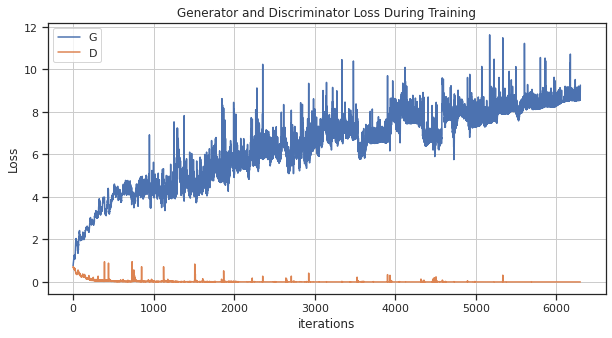

In [87]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="G")
plt.plot(D_loss_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_time_series_inception_class.png')
plt.show()

## test

In [88]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [89]:
test_well = wells[22]
test_well

'well_17.json'

In [90]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [91]:
y_name = 'DEPTH'

In [92]:
X_test

,DEPTH,ROPA,HKLA,WOB,SPPA
0,223.0,1.50,96.39,0.19,84.75
1,224.0,3.84,97.11,0.60,77.10
2,225.0,3.51,96.76,0.58,85.56
3,226.0,21.85,97.11,0.36,53.67
4,227.0,33.79,94.76,2.55,53.96
...,...,...,...,...,...
3405,3628.0,15.04,156.24,5.77,218.70
3406,3629.0,15.04,155.61,6.36,218.79
3407,3630.0,15.04,155.27,6.58,218.60
3408,3631.0,15.04,155.71,6.26,218.71


In [93]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = generator(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [94]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [95]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:03<00:00, 210.92it/s]


837it [00:00, 132686.99it/s]
/tmp/ipykernel_18223/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 155310.23it/s]
/tmp/ipykernel_18223/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 178639.96it/s]
/tmp/ipykernel_18223/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 182655.17it/s]
/tmp/ipykernel_18223/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 176751.21it/s]
/tmp/ipykernel_18223/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


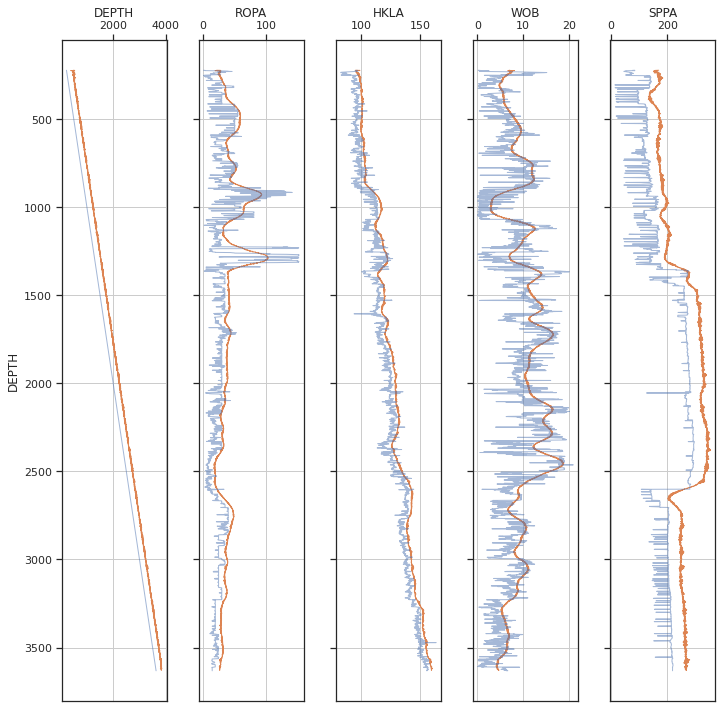

In [96]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()


In [97]:
df1 = pd.DataFrame(original).T
df1.columns = required_params
df1 = df1.assign(WELL=lambda x: 'original')

df2 = pd.DataFrame(generated).T
df2.columns = required_params
df2 = df2.assign(WELL=lambda x: 'generated')

df_some = pd.concat([df1, df2], ignore_index = True)
df_some

,DEPTH,ROPA,HKLA,WOB,SPPA,WELL
0,223.000000,1.500000,96.390000,0.190000,84.750000,original
1,224.000000,3.840000,97.110000,0.600000,77.100000,original
2,225.000000,3.510000,96.760000,0.580000,85.560000,original
3,226.000000,21.850000,97.110000,0.360000,53.670000,original
4,227.000000,33.790000,94.760000,2.550000,53.960000,original
...,...,...,...,...,...,...
6813,3827.166168,26.954540,159.267323,4.454938,266.663976,generated
6814,3830.842117,26.716468,159.365762,4.660939,267.053649,generated
6815,3838.715637,26.394381,159.198082,4.664370,265.966693,generated
6816,3832.157639,26.483802,159.329444,4.690721,268.068808,generated


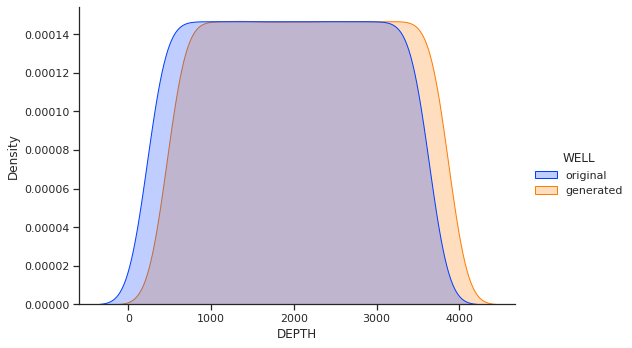

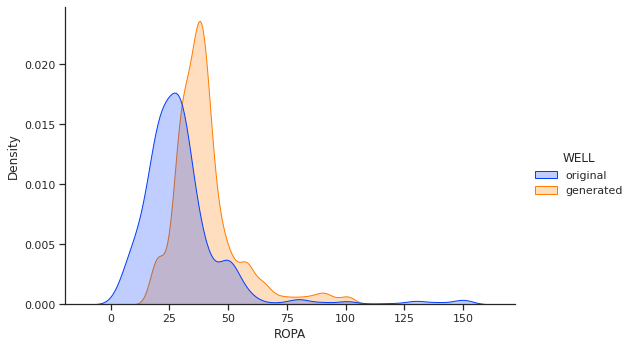

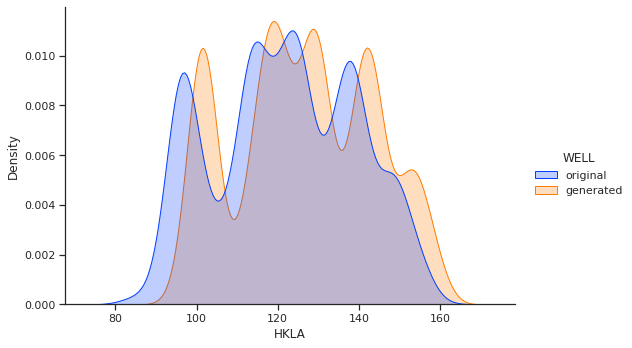

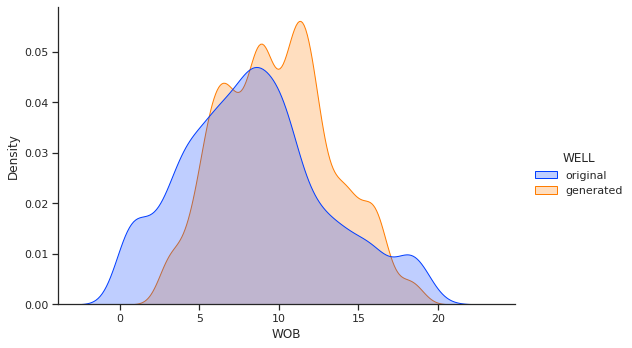

In [98]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )